In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorboard
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (18, 10)})
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.5.0
Tensorflow version: 2.5.0


# Hyper Parameters

In [ ]:
global AF
# AF = keras.layers.LeakyReLU()
AF = keras.layers.ReLU()
seq_len = 16

# Import Data

# Preprocessing

In [ ]:
df = pd.read_csv('IBM.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
for i in range(df.shape[0]):
    df.loc[i, 'day_of_week'] = df.loc[i, 'Date'].dayofweek + 1
df['day_number'] = df['Date'].dt.day
df.head()

In [ ]:
onehot = pd.get_dummies(df['day_of_week'])
df = df.join(onehot)

df.index = df.Date
df = df[df['Date'] >= '1990-01-01']

df[['Date', 'day_of_week', 1, 2, 3, 4, 5]].head()

In [ ]:
df['Return'] = df.Close - df.Open
df['DailyVolatility'] = df.High - df.Low
ewdf = df.ewm(halflife = 10).mean()
vewdf = df.ewm(halflife = 10).var()
scaled = df.DailyVolatility - ewdf.DailyVolatility
scaled = scaled / vewdf.DailyVolatility**0.5

In [ ]:
df['ScaledVolatility'] = ((df.DailyVolatility - ewdf.DailyVolatility) /
                          vewdf.DailyVolatility**0.5 )
df['ScaledReturn'] = ((df.Return - ewdf.Return) / vewdf.Return**0.5 )
df['ScaledVolume'] = ((df.Volume - ewdf.Volume) / vewdf.Volume**0.5 )
df = df.dropna()
df.head()

In [ ]:
val_start  = int((df.shape[0]) * 0.8)
test_start = int((df.shape[0]) * 0.9)

train_data = df[:val_start][["ScaledVolatility", "ScaledReturn",
                             "ScaledVolume", 1, 2, 3, 4, 5]].values
val_data = df[val_start:test_start][["ScaledVolatility", "ScaledReturn",
                                     "ScaledVolume", 1, 2, 3, 4, 5]].values
test_data  = df[test_start:][["ScaledVolatility", "ScaledReturn",
                              "ScaledVolume", 1, 2, 3, 4, 5]].values
train_data.shape, val_data.shape, test_data.shape

In [ ]:
fig = plt.figure(figsize=(25,15))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax2 = fig.add_subplot(311)
ax2.plot(np.arange(train_data.shape[0]), train_data[:, 0], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 0], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 0], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Volatility')
ax2.set_title("Scaled Volatility", fontsize=18)
ax2.legend(loc="best", fontsize=12)

###############################################################################

ax1 = fig.add_subplot(312)
ax1.plot(np.arange(train_data.shape[0]), train_data[:, 1], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 1], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 1], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Scaled Return')
ax1.set_title("Scaled Return", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(313)
ax2.plot(np.arange(train_data.shape[0]), train_data[:, 2], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 2], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 2], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Volume')
ax2.set_title("Scaled Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.savefig('Data Seperation.png', pad_inches=0, bbox_inches='tight')


## Window Size

In [ ]:
target_index =1
# Training data
seq_len = 16
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, target_index][i])
X_train, y_train = np.array(X_train), np.array(y_train)
###############################################################################
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, target_index][i])
X_val, y_val = np.array(X_val), np.array(y_val)
###############################################################################
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, target_index][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

In [ ]:
y_train == df[seq_len:val_start]['ScaledReturn']

# Model

## positional_encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## scaled_dot_product_attention

In [ ]:
def scaled_dot_product_attention(q, k, v):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], np.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  # attention_weights.shape=(..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## MultiHeadAttention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, q_dim=32, v_dim=None):
    super(MultiHeadAttention, self).__init__()

    self.num_heads = num_heads
    self.d_model = d_model
    k_dim = q_dim
    if v_dim == None:
        v_dim = q_dim
    self.q_dim = q_dim
    self.k_dim = k_dim
    self.v_dim = v_dim

    self.depth = q_dim // self.num_heads # 8 = 32 // 4

    self.wq = tf.keras.layers.Dense(q_dim)
    self.wk = tf.keras.layers.Dense(k_dim)
    self.wv = tf.keras.layers.Dense(v_dim)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # (N, 32, 4, 8)
    return tf.transpose(x, perm=[0, 2, 1, 3]) # (N, 4, 32, 8)

  def call(self, v, k, q):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)

    # scaled_attention.shape == (batch_size, seq_len_q, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concat_attention.shape == (batch_size, seq_len_q, d_model)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.q_dim))

    # output.shape == (batch_size, seq_len_q, d_model)
    output = self.dense(concat_attention)

    return output, attention_weights

## point_wise_feed_forward_network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation=AF, name='dff_1'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model, activation=AF, name='dff_2')  # (batch_size, seq_len, d_model)
  ])

## EncoderLayer

In [ ]:

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, q_dim, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads, q_dim)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training=True):

    # attn_output.shape == (batch_size, input_seq_len, d_model)
    attn_output, attention_weights = self.mha(x, x, x)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)


    return out2, attention_weights

## Encoder

In [ ]:


class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, q_dim, dff,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.my_embedding = tf.keras.layers.Dense(d_model, activation='linear')
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.num_layers = num_layers
    self.enc_layers = [EncoderLayer(d_model, num_heads, q_dim, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training=True):
    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.my_embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    att_w = []
    for i in range(self.num_layers):
      x, attention_weights = self.enc_layers[i](x, training)
      att_w.append(attention_weights)

    self.attention_weights = att_w

    return x # (batch_size, input_seq_len, d_model)

In [ ]:
import tensorflow_probability as tfp
def corr(y_true, y_pred):
    l = tfp.stats.correlation(y_true, y_pred)
    return l

## Model

In [ ]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1)

In [ ]:
def create_model(num_layers=8, d_model=8, num_heads=4, q_dim=16,
                 dff=64, n_features=X_train.shape[-1], rate=0.1):

    global lr
    lr = 1e-4
    global epochs
    epochs = 50

    global model_str
    model_str = f'seq_len={seq_len}, num_layers={num_layers}, d_model={d_model}, \
    num_heads={num_heads}, q_dim={q_dim}, dff={dff}, lr={lr}, epochs={epochs}'

    encoder = Encoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        q_dim = q_dim,
        dff=dff,
        maximum_position_encoding=seq_len,
        rate=rate)

    '''Construct model'''

    input = tf.keras.layers.Input(shape=(seq_len, n_features))
    x = encoder(input)

    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(1, 'linear')(x)

    model = tf.keras.models.Model(inputs=input, outputs=out)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=[corr, 'mape'])

    return model


model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 8)]           0         
_________________________________________________________________
encoder (Encoder)            (None, 16, 8)             13640     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 13,769
Trainable params: 13,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# def scheduler(epoch, lr):
#     if epoch > 20:
#         lr = 5e-5
#     if epoch > 50:
#         lr = 1e-5
#     print('learning_rate:', lr)
#     return lr
# !rm n*
# !rm *.h5

path_w = 'model_str.tf'
callbackCheckpoint = keras.callbacks.ModelCheckpoint(path_w,
                                                    monitor='val_corr',
                                                    save_best_only=True,
                                                    save_weights_only= True,
                                                    mode='max')


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
batch_size = 32
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[callbackCheckpoint]
                    )

Epoch 1/50
199/199 [==============================] - 82s 67ms/step - loss: 1.1868 - corr: 0.0352 - mape: 388.5385 - val_loss: 0.8413 - val_corr: 0.0111 - val_mape: 162.4291
Epoch 2/50
199/199 [==============================] - 11s 55ms/step - loss: 0.9656 - corr: 0.0094 - mape: 257.5819 - val_loss: 0.8358 - val_corr: 0.0196 - val_mape: 182.1463
Epoch 3/50
199/199 [==============================] - 11s 55ms/step - loss: 0.9345 - corr: 0.0025 - mape: 264.2151 - val_loss: 0.8522 - val_corr: 0.0322 - val_mape: 238.2450
Epoch 4/50
199/199 [==============================] - 11s 54ms/step - loss: 0.9146 - corr: 0.0085 - mape: 236.1918 - val_loss: 0.8253 - val_corr: 0.0193 - val_mape: 150.0273
Epoch 5/50
199/199 [==============================] - 11s 54ms/step - loss: 0.9005 - corr: 0.0152 - mape: 221.9412 - val_loss: 0.8298 - val_corr: 0.0298 - val_mape: 170.3209
Epoch 6/50
199/199 [==============================] - 11s 55ms/step - loss: 0.8972 - corr: -0.0021 - mape: 204.7384 - val_loss: 0.

In [ ]:
 '''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Train Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Valid Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test  Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

train_pred = np.squeeze(train_pred)
val_pred = np.squeeze(val_pred)
test_pred = np.squeeze(test_pred)

a = stats.pearsonr(y_train, train_pred)
b = stats.pearsonr(y_val, val_pred)
c = stats.pearsonr(y_test, test_pred)
print('--------------------------------------------------------------------------')
print('Pearson correlation: y train predicted vs y actual train: {:.4f}' .format(a[0]))
print('Pearson correlation: y valid predicted vs y actual valid: {:.4f}' .format(b[0]))
print('Pearson correlation: y test  predicted vs y actual test : {:.4f}' .format(c[0]))



l = []
l.append('---------------------------------------------------------------------------------')
l.append(model_str)
l.append('Train Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
l.append('Valid Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
l.append('Test  Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))
l.append('Pearson correlation: y train predicted vs y actual train: {:.4f}' .format(a[0]))
l.append('Pearson correlation: y valid predicted vs y actual valid: {:.4f}' .format(b[0]))
l.append('Pearson correlation: y test  predicted vs y actual test : {:.4f}' .format(c[0]))

with open(f'{directory}/results.txt', 'w') as f:
    for i in l:
        f.write('%s\n' % i)

 
Evaluation metrics
Train Data - Loss: 0.8283, MAE: 0.2030, MAPE: 145.1586
Valid Data - Loss: 0.8126, MAE: 0.1566, MAPE: 181.5953
Test  Data - Loss: 0.8204, MAE: 0.2337, MAPE: 179.1818
--------------------------------------------------------------------------
Pearson correlation: y train predicted vs y actual train: 0.1505
Pearson correlation: y valid predicted vs y actual valid: 0.1314
Pearson correlation: y test  predicted vs y actual test : 0.1552


In [ ]:
print(np.var(train_pred))
print(np.mean(train_pred))

0.009916247
0.05215074


In [ ]:
tresh = np.max(y_train) / np.max(train_pred)
print(tresh)
train_pred = [x*tresh for x in train_pred]
val_pred = [x*tresh for x in val_pred]
test_pred = [x*tresh for x in test_pred]
train_pred = np.array(train_pred)
val_pred = np.array(val_pred)
test_pred = np.array(test_pred)


6.09730731649112


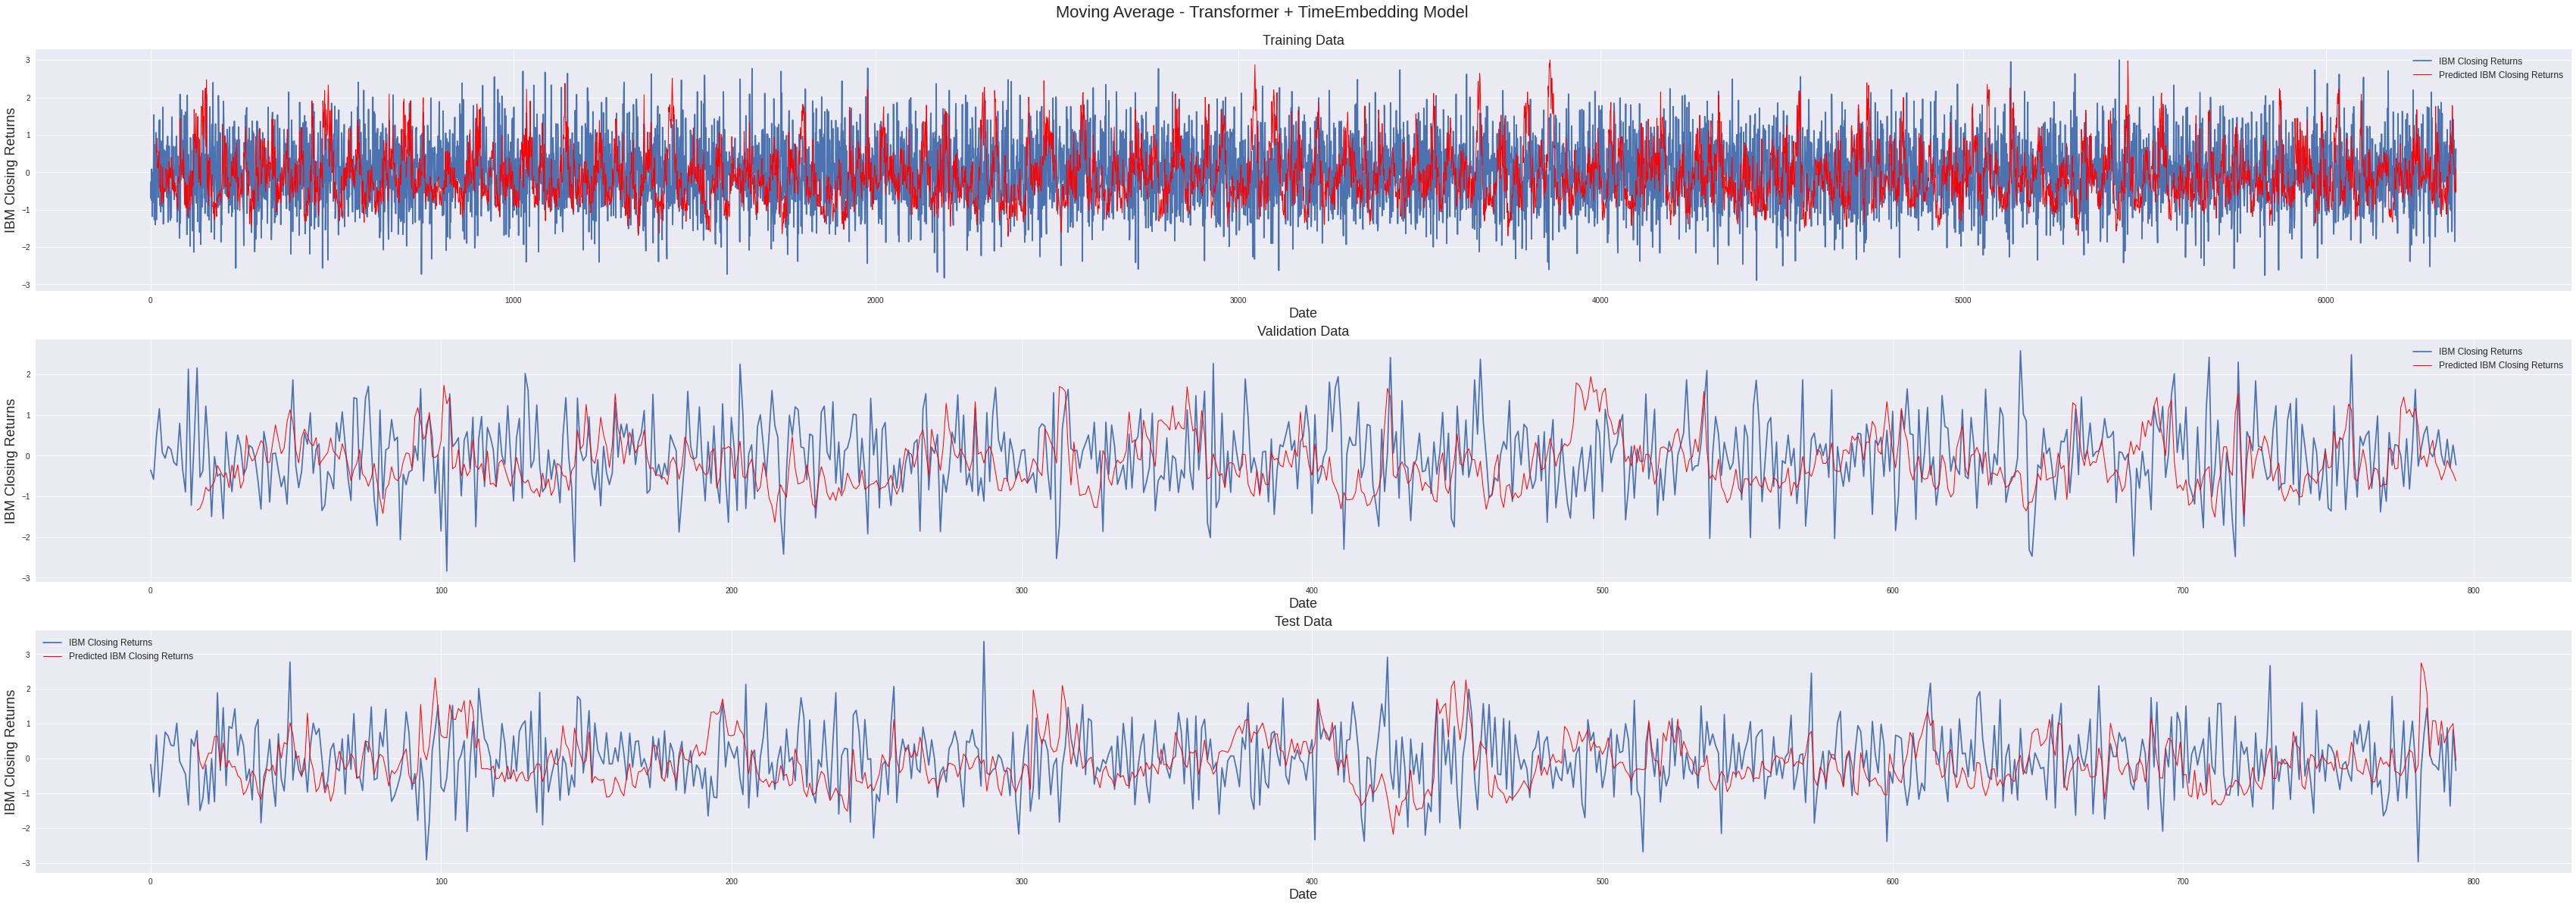

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(60,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, target_index], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date', fontsize=18)
ax11.set_ylabel('IBM Closing Returns', fontsize=18)
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, target_index], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred , linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date', fontsize=18)
ax21.set_ylabel('IBM Closing Returns', fontsize=18)
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, target_index], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date', fontsize=18)
ax31.set_ylabel('IBM Closing Returns', fontsize=18)
ax31.legend(loc="best", fontsize=12)
plt.savefig('resluts.png', pad_inches=0, bbox_inches='tight')

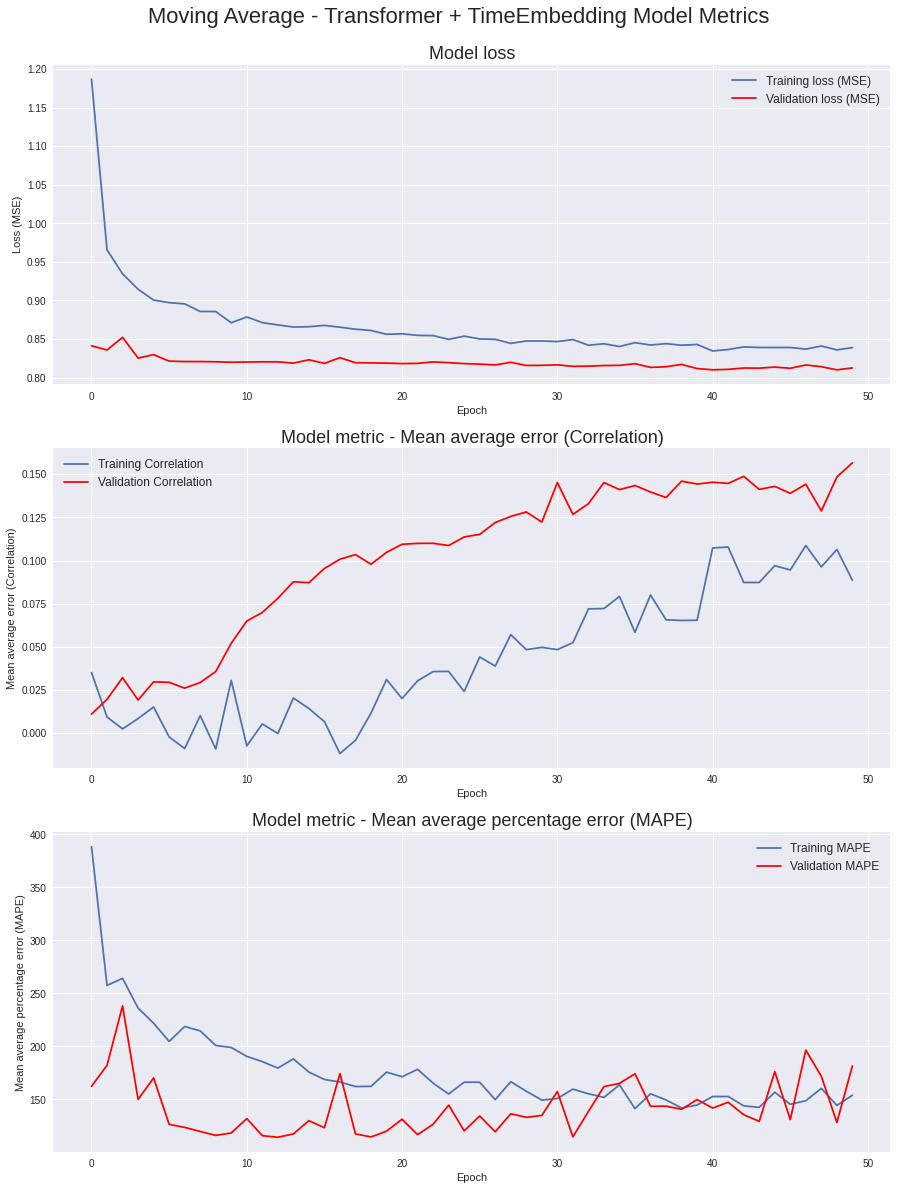

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)', c='r')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['corr'], label='Training Correlation')
ax2.plot(history.history['val_corr'], label='Validation Correlation', c='r')
ax2.set_title("Model metric - Mean average error (Correlation)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (Correlation)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE', c='r')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)
plt.savefig('metrics.png', pad_inches=0, bbox_inches='tight')

# Test

In [ ]:
target_index =1
# Training data
seq_len = 16
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, target_index][i])
X_train, y_train = np.array(X_train), np.array(y_train)
###############################################################################
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, target_index][i])
X_val, y_val = np.array(X_val), np.array(y_val)
###############################################################################
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, target_index][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6344, 16, 8) (6344,)
(779, 16, 8) (779,)


In [ ]:
def create_model(num_layers=8, d_model=16, num_heads=8, q_dim=32,
                 dff=64, n_features=X_train.shape[-1], rate=0.1):

    global lr
    lr = 1e-4
    global epochs
    epochs = 50
    dff = 4*q_dim
    global model_str
    model_str = f'seq_len={seq_len}, num_layers={num_layers}, d_model={d_model}, \
num_heads={num_heads}, q_dim={q_dim}, dff={dff}, lr={lr}, epochs={epochs}'

    encoder = Encoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        q_dim = q_dim,
        dff=dff,
        maximum_position_encoding=seq_len,
        rate=rate)

    '''Construct model'''

    input = tf.keras.layers.Input(shape=(seq_len, n_features))
    x = encoder(input)

    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(1, 'linear')(x)

    model = tf.keras.models.Model(inputs=input, outputs=out)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=[corr, 'mape'])

    return model


model = create_model()
model.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 16, 8)]           0         
_________________________________________________________________
encoder_43 (Encoder)         (None, 16, 16)            51856     
_________________________________________________________________
flatten_43 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_1463 (Dense)           (None, 1)                 257       
Total params: 52,113
Trainable params: 52,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[callbackCheckpoint]
                    )

Epoch 1/50
199/199 [==============================] - 15s 37ms/step - loss: 1.3579 - corr: 0.0153 - mape: 469.2942 - val_loss: 0.8286 - val_corr: 3.3764e-05 - val_mape: 164.7478
Epoch 2/50
199/199 [==============================] - 6s 30ms/step - loss: 0.9297 - corr: 0.0302 - mape: 263.6205 - val_loss: 0.8230 - val_corr: 0.0277 - val_mape: 139.9196
Epoch 3/50
199/199 [==============================] - 6s 30ms/step - loss: 0.9236 - corr: -0.0098 - mape: 257.6479 - val_loss: 0.8254 - val_corr: 0.0477 - val_mape: 143.1416
Epoch 4/50
199/199 [==============================] - 6s 30ms/step - loss: 0.8961 - corr: 0.0310 - mape: 237.6363 - val_loss: 0.8211 - val_corr: 0.0531 - val_mape: 121.1515
Epoch 5/50
199/199 [==============================] - 6s 32ms/step - loss: 0.8980 - corr: 0.0146 - mape: 238.1797 - val_loss: 0.8263 - val_corr: 0.0521 - val_mape: 153.0539
Epoch 6/50
199/199 [==============================] - 6s 32ms/step - loss: 0.8890 - corr: 0.0147 - mape: 221.3093 - val_loss: 0.8

In [ ]:
model = create_model()
model.load_weights(path_w)

In [ ]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Train Data - Loss: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[2]))
print('Valid Data - Loss: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[2]))
print('Test  Data - Loss: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[2]))

train_pred = np.squeeze(train_pred)
val_pred = np.squeeze(val_pred)
test_pred = np.squeeze(test_pred)

a = stats.pearsonr(y_train, train_pred)
b = stats.pearsonr(y_val, val_pred)
c = stats.pearsonr(y_test, test_pred)
print('--------------------------------------------------------------------------')
print('Pearson correlation: y train predicted vs y actual train: {:.4f}' .format(a[0]))
print('Pearson correlation: y valid predicted vs y actual valid: {:.4f}' .format(b[0]))
print('Pearson correlation: y test  predicted vs y actual test : {:.4f}' .format(c[0]))


l = []
l.append('--------------------------------------------------------------------------------------')
l.append(model_str)
l.append('Train Data - Loss: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[2]))
l.append('Valid Data - Loss: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[2]))
l.append('Test  Data - Loss: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[2]))
l.append('Pearson correlation: y train predicted vs y actual train: {:.4f}' .format(a[0]))
l.append('Pearson correlation: y valid predicted vs y actual valid: {:.4f}' .format(b[0]))
l.append('Pearson correlation: y test  predicted vs y actual test : {:.4f}' .format(c[0]))

 
Evaluation metrics
Train Data - Loss: 0.8239, MAPE: 151.1869
Valid Data - Loss: 0.8103, MAPE: 159.4874
Test  Data - Loss: 0.8203, MAPE: 166.1803
--------------------------------------------------------------------------
Pearson correlation: y train predicted vs y actual train: 0.1505
Pearson correlation: y valid predicted vs y actual valid: 0.1240
Pearson correlation: y test  predicted vs y actual test : 0.1322


In [ ]:

print(np.var(train_pred))
print(np.mean(train_pred))
tresh = np.max(y_train) / np.max(train_pred)
print(tresh)
train_pred = [x*tresh for x in train_pred]
val_pred = [x*tresh for x in val_pred]
test_pred = [x*tresh for x in test_pred]
train_pred = np.array(train_pred)
val_pred = np.array(val_pred)
test_pred = np.array(test_pred)


0.014334681
-0.0011846315
4.6154306234808695


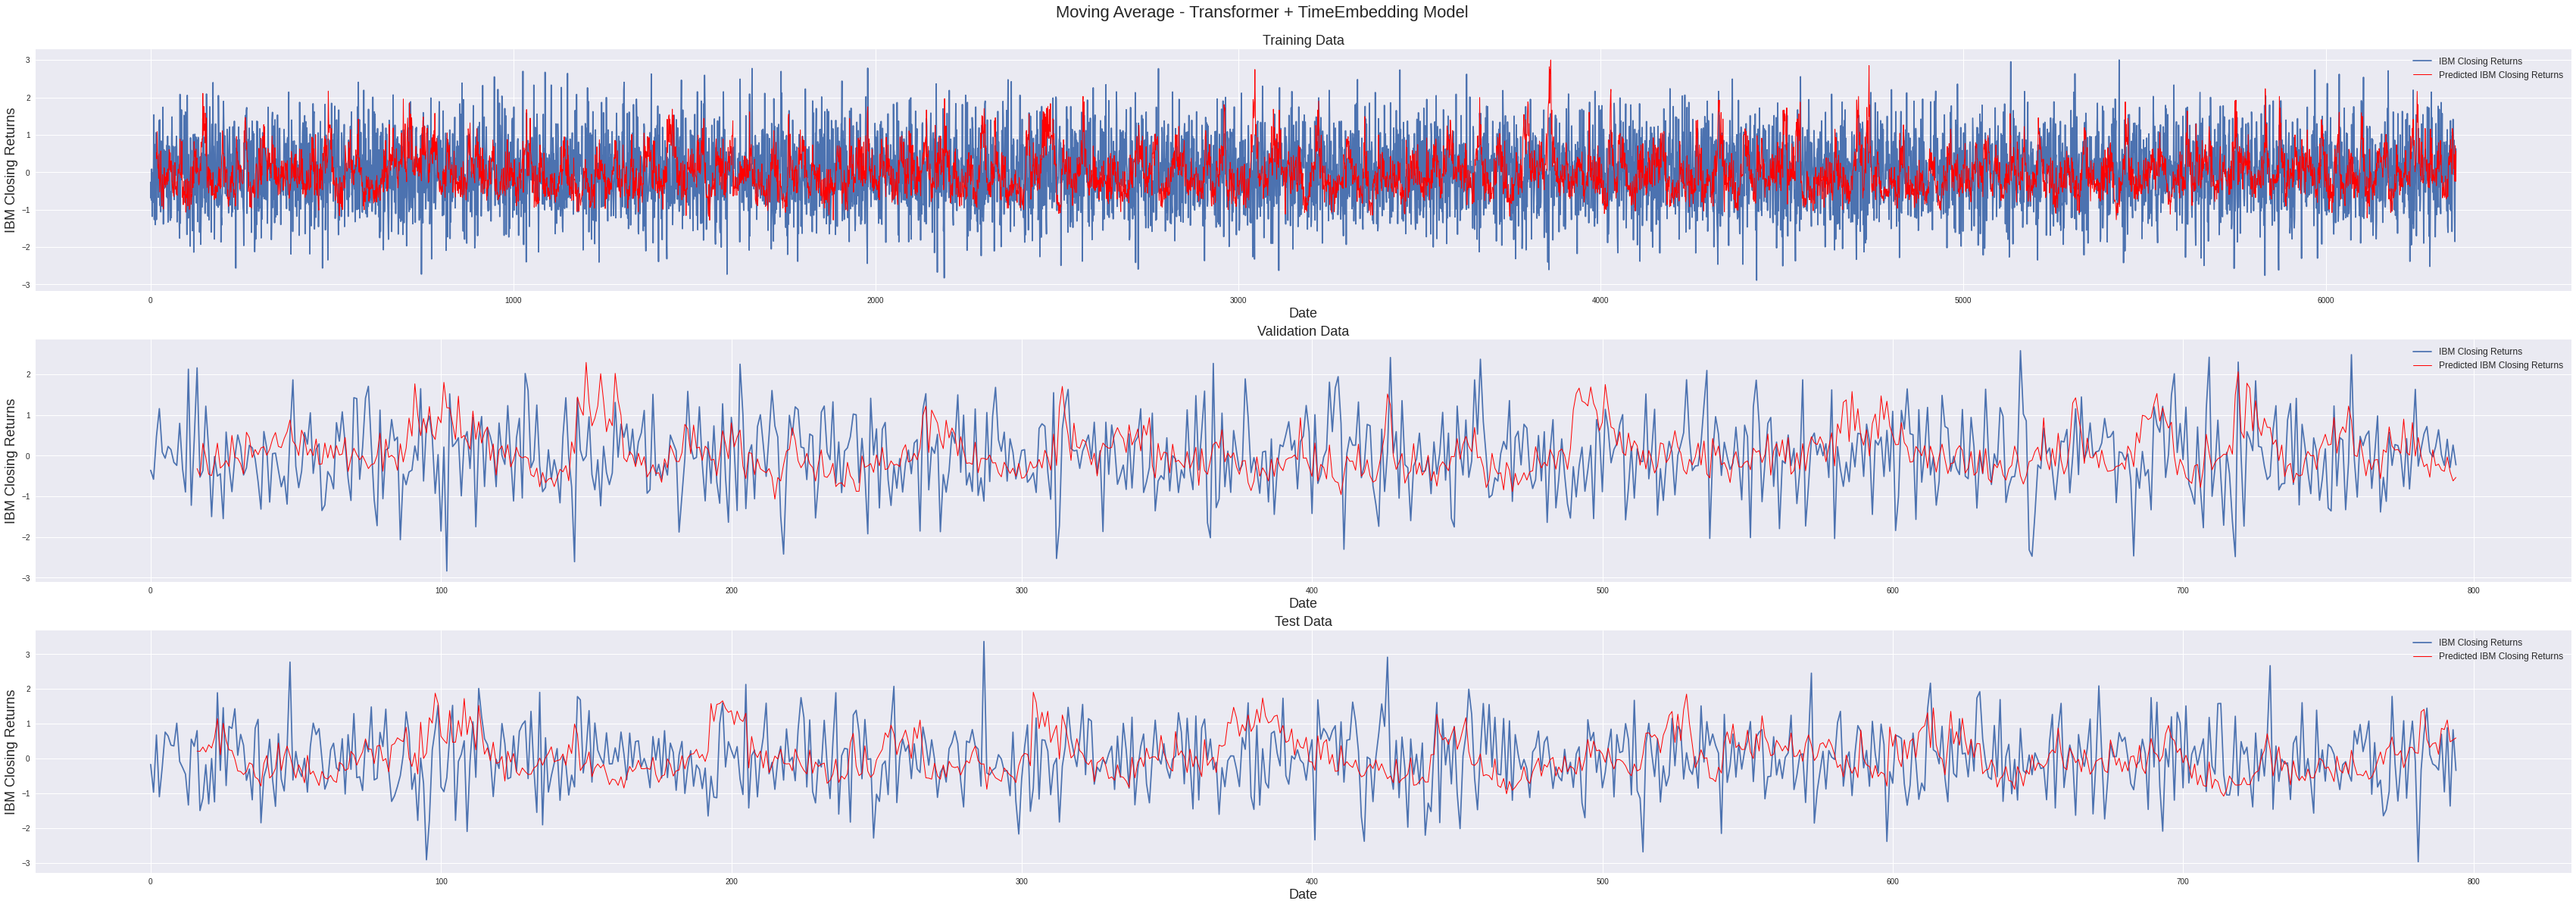

In [ ]:

'''Display results'''

fig = plt.figure(figsize=(60,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, target_index], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date', fontsize=18)
ax11.set_ylabel('IBM Closing Returns', fontsize=18)
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, target_index], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred , linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date', fontsize=18)
ax21.set_ylabel('IBM Closing Returns', fontsize=18)
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, target_index], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=1, c='r', label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date', fontsize=18)
ax31.set_ylabel('IBM Closing Returns', fontsize=18)
ax31.legend(loc="best", fontsize=12)
plt.savefig('resluts.png', pad_inches=0, bbox_inches='tight')



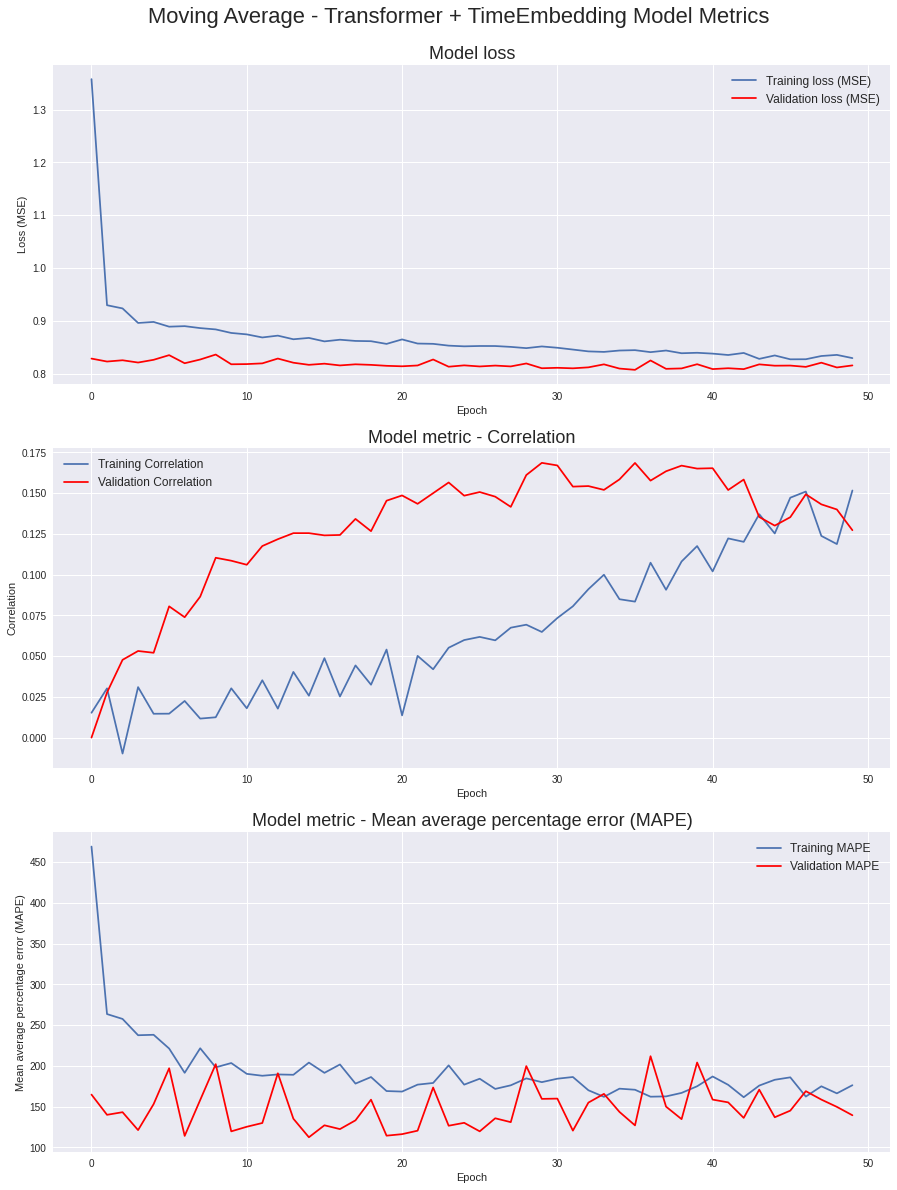

In [ ]:

'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)', c='r')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['corr'], label='Training Correlation')
ax2.plot(history.history['val_corr'], label='Validation Correlation', c='r')
ax2.set_title("Model metric - Correlation", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Correlation')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE', c='r')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)
plt.savefig('metrics.png', pad_inches=0, bbox_inches='tight')



In [ ]:
Seq_len=16, num_layers=8, d_model=8, num_heads=4, q_dim=16, dff=64, lr=0.0001, epochs=50